In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

https://github.com/nisode/MSDS/tree/main/Deep%20Learning

# Load Data

In [3]:
train = pd.read_csv(f'../input/histopathologic-cancer-detection/train_labels.csv', dtype='str')

# Task

Our task is to develop a neural network to identify Histopathologic Cancer. 

There are a little over 220,000 images in the dataset. 

Images are provided in 96 x 96px RGB (full color) format. 

A positive label (1) will indicate at least one of those 1024 pixels in the 32 x 32px center contains a cancer tissue. 

Kaggle indicates that there are no duplicates in the dataset.

# EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [5]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The csv has two columns and indicates that there are 220,025 image and corresponding labels in the training set.

id seems to be a unique identifier string to the image name in the training folder 

label seems to be 1, 0 binary representation of cancer or not

In [6]:
from matplotlib import pyplot as plt

Let's take a look at the label relative frequencies. 

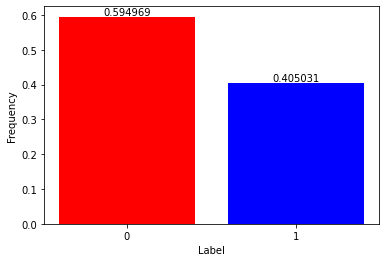

In [7]:
fig = plt.bar(['0', '1'], train['label'].value_counts()/len(train), color=['red', 'blue'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.bar_label(fig)
plt.show()

In [8]:
train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

Nearly 60 percent of labels were 0 and 40 percent were 1 so it is an imbalanced set. There are about 89k positive labels vs about 131k negative labels. There are concerns that this will cause the model to over predict toward 0.

In [9]:
import matplotlib.image as mpimg

Let's take a look at the first 18 images:

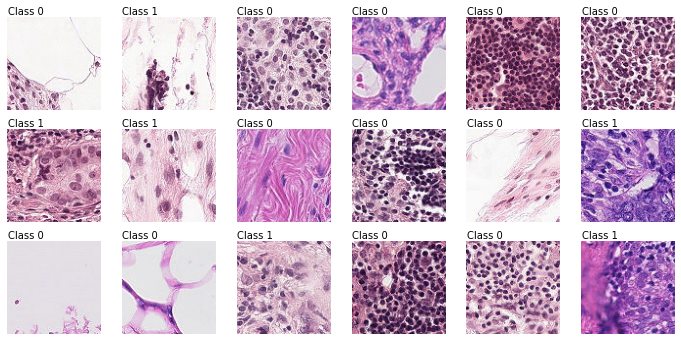

In [10]:
path_train = r'../input/histopathologic-cancer-detection/train/'

plt.figure(figsize=(12,12))

for i in range(18):
    img = mpimg.imread(path_train + train.iloc[i]['id'] + '.tif')
    label = train.iloc[i]['label']
    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0,-3,f'Class {label}')
    plt.axis('off')

As we can see, images are in color and mostly contain some cells in the center of the image. Some have noticeably less interesting features than others such as the one on the bottom left.

To be honest, I have no idea what the visual differences between class 1 or class 0 would be.

Let's take a closer look at a single image that was labeled 1 (cancer).

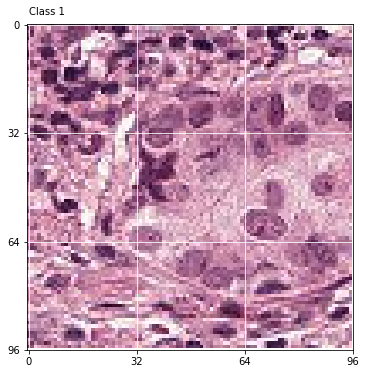

In [11]:
plt.figure(figsize=(6,6))
img = mpimg.imread(path_train + train.iloc[6]['id'] + '.tif')
label = train.iloc[6]['label']
plt.imshow(img)
plt.text(0,-3,f'Class {label}')
plt.grid(color='white')
plt.xticks(np.linspace(0, 96, 4))
plt.yticks(np.linspace(0, 96, 4))
plt.show()

In the center 32 x 32px square there is at least a single pixel of cancer tissue. Without medical knowledge, I have no idea what I'm looking at, but hopefully a NN model can figure it out.

Now let's take a closer look at one without cancer.

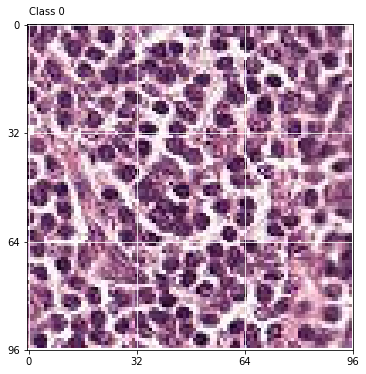

In [12]:
plt.figure(figsize=(6,6))
img = mpimg.imread(path_train + train.iloc[5]['id'] + '.tif')
label = train.iloc[5]['label']
plt.imshow(img)
plt.text(0,-3,f'Class {label}')
plt.grid(color='white')
plt.xticks(np.linspace(0, 96, 4))
plt.yticks(np.linspace(0, 96, 4))
plt.show()

The entire center 32x32 px square has no pixels that contain cancer tissue.

# Data Cleaning

We should check for bad images that are either too dark or too light. 

These values are currently set so that if image max values are less than 10 or if min values are greater than 245, then they will be considered bad.

These would be 10 off from the min and max of 255 so if the entire image is only at most 10 values off from min and max, it'd be really hard to see any details in them and so it would cause problems to the algorthms.

This takes a really long time to run so I'm not gonna try to adjust these values.

In [13]:
#this runs way too long so we will skip it for future
'''from PIL import Image

bad_images = []
bad_idx = []

for i in range(220025):
    img = Image.open(path_train + train.iloc[i]['id'] + '.tif')
    img_array = np.array(img)
    if img_array.max() < 10 or img_array.min() > 245:
        bad_images.append(train.iloc[i]['id'])
        bad_idx.append(i)
        
bad_images'''

"from PIL import Image\n\nbad_images = []\nbad_idx = []\n\nfor i in range(220025):\n    img = Image.open(path_train + train.iloc[i]['id'] + '.tif')\n    img_array = np.array(img)\n    if img_array.max() < 10 or img_array.min() > 245:\n        bad_images.append(train.iloc[i]['id'])\n        bad_idx.append(i)\n        \nbad_images"

In [14]:
'''bad_idx'''

'bad_idx'

In [15]:
bad_images = ['9071b424ec2e84deeb59b54d2450a6d0172cf701',
 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b',
 '5f30d325d895d873d3e72a82ffc0101c45cba4a8',
 '54df3640d17119486e5c5f98019d2a92736feabc',
 '9369c7278ec8bcc6c880d99194de09fc2bd4efbe',
 '5a268c0241b8510465cb002c4452d63fec71028a',
 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83']

bad_images

['9071b424ec2e84deeb59b54d2450a6d0172cf701',
 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b',
 '5f30d325d895d873d3e72a82ffc0101c45cba4a8',
 '54df3640d17119486e5c5f98019d2a92736feabc',
 '9369c7278ec8bcc6c880d99194de09fc2bd4efbe',
 '5a268c0241b8510465cb002c4452d63fec71028a',
 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83']

Just to see what these images look like, they are almost entirely black or entirely white.

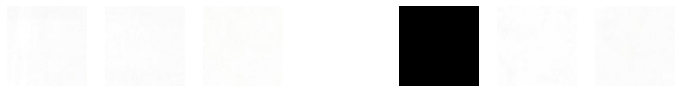

In [16]:
plt.figure(figsize=(12,12))

for i in range(len(bad_images)):
    img = mpimg.imread(path_train + bad_images[i] + '.tif')
    plt.subplot(7,7,i+1)
    plt.imshow(img)
    plt.axis('off')

In [17]:
bad_idx = [436, 9169, 65242, 136288, 138245, 144762, 148911]

Let's drop these images and print their ids to make sure we picked the right ones to drop.

In [18]:
for idx in bad_idx:
    print("Drop:", train.iloc[idx]['id'])
    train.drop(idx, inplace=True)

Drop: 9071b424ec2e84deeb59b54d2450a6d0172cf701
Drop: 401fdeaa6643b4d65125a5d1c14a35529b0effed
Drop: efb45e90548b8fe9a5b1613a8978fb9c1659251e
Drop: 063d6daa6a153242802e3e1000d3bfbcfefca2c9
Drop: 548643ec3f62a70b990ca94aeb7a85e900ae5934
Drop: 995266fb2b46334bf3111f6793a463c8bba5270f
Drop: 83bc070567adeb7ecacb06a14cd09c6c67d6a9c4


Next we'll balance the remaining dataset so that it doesn't just pick the more dominant label.

There were 89111 positive labels, but let's just pick 89000 to have even numbers for splitting.

In [19]:
train_0 = train[train['label'] == '0'].sample(89000, random_state=123)
train_1 = train[train['label'] == '1'].sample(89000, random_state=123)

train_df = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=123).reset_index(drop=True)

train_df['label'].value_counts()

0    89000
1    89000
Name: label, dtype: int64

In [21]:
train_df.head()

,id,label
0,2ad6826359253a863ceb2c7c277d8740c6c09f24,0
1,80a340b5226e0e9ec2cec09a9c3e3cccc1c8809e,0
2,0751098afb887d2283f1aa877c244d7df26da77a,1
3,ec478c0aa47dae2865bf2fdefc7d3d3f28a9527e,1
4,2a61bbf9bffabab9c9c5d9676d6042e8d0763f46,1


Let's add in the .tif so we can load images easier in the future

In [20]:
train_df['id'] = train_df['id'] + '.tif'
train_df.head()

,id,label
0,2ad6826359253a863ceb2c7c277d8740c6c09f24.tif,0
1,80a340b5226e0e9ec2cec09a9c3e3cccc1c8809e.tif,0
2,0751098afb887d2283f1aa877c244d7df26da77a.tif,1
3,ec478c0aa47dae2865bf2fdefc7d3d3f28a9527e.tif,1
4,2a61bbf9bffabab9c9c5d9676d6042e8d0763f46.tif,1


Now let's split and shuffle the data with 20% to validation set. Along the way, we will rescale values as float by dividing by 255.

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             validation_split = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True
                            )

train_data = datagen.flow_from_dataframe(dataframe = train_df,
                                        directory = path_train,
                                        x_col = "id",
                                        y_col = "label",
                                        subset = "training",
                                        batch_size = 32,
                                        seed = 123,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (96,96))

valid_data = datagen.flow_from_dataframe(dataframe = train_df,
                                        directory = path_train,
                                        x_col = "id",
                                        y_col = "label",
                                        subset = "validation",
                                        batch_size = 32,
                                        seed = 123,
                                        shuffle = False,
                                        class_mode = "binary",
                                        target_size = (96,96))

Found 142400 validated image filenames belonging to 2 classes.
Found 35600 validated image filenames belonging to 2 classes.


# Model Architechture

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Set seed for repeatability

In [24]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [25]:
cnn_model1 = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu', input_shape = (96, 96, 3)),
    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),
    
    Flatten(),
    Dense(60, activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_model1.compile(optimizer = Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999), 
                   loss="binary_crossentropy", 
                   metrics = ['accuracy', tf.keras.metrics.AUC()])

2022-08-15 09:36:57.970521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 09:36:57.971377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 09:36:57.972096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 09:36:57.973199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 09:36:57.973977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [26]:
cnn_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 60)                8

Some thought process behind the thought procress of this initial model:

1. input_shape to match image size
2. many 3x3 filters better than 5x5 and 7x7 for number of parameters
3. relu seems to work well with just about everything
4. tried two layers to see if it works well
5. max pooling and drop out seem to be used a lot and can help with some features
6. flatten and then 2 dense layer to an output layer
7. only one output needed for binary
8. first attempt will be using default values for Adam which seems to be a popular optimizer
9. binary cross entropy for loss since classification is binary

In [29]:
cnn_model2 = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu', input_shape = (96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),
    
    Flatten(),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_model2.compile(optimizer = Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999), 
                   loss="binary_crossentropy", 
                   metrics = ['accuracy', tf.keras.metrics.AUC()])

cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2211870   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

This second model that we will try will be a simpler version of the previous one with one convulation layer instead of two and one dense layer rater than 2 before the output. Otherwise this is very similar, I just wanted something that would train faster as the previous one took forever to run and my connection isn't good enough to guarentee long run time finishes. The amount of parameters in the smaller model is about 1/4 the amount in the original model.

# Results

In [28]:
model1_hist = cnn_model1.fit(x = train_data,
                            validation_data = valid_data,
                            epochs = 10,
                            verbose = 1)

2022-08-15 09:37:09.461420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-15 09:37:11.452006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4450/4450 [==============================] - 1065s 238ms/step - loss: 0.4746 - accuracy: 0.7830 - auc: 0.8583 - val_loss: 0.4872 - val_accuracy: 0.7905 - val_auc: 0.8851
Epoch 2/10
4450/4450 [==============================] - 329s 74ms/step - loss: 0.4210 - accuracy: 0.8105 - auc: 0.8887 - val_loss: 0.4657 - val_accuracy: 0.7977 - val_auc: 0.8701
Epoch 3/10
4450/4450 [==============================] - 268s 60ms/step - loss: 0.3901 - accuracy: 0.8276 - auc: 0.9058 - val_loss: 0.4090 - val_accuracy: 0.8141 - val_auc: 0.9116
Epoch 4/10
4450/4450 [==============================] - 265s 60ms/step - loss: 0.3667 - accuracy: 0.8405 - auc: 0.9172 - val_loss: 0.3873 - val_accuracy: 0.8262 - val_auc: 0.9209
Epoch 5/10
4450/4450 [==============================] - 273s 61ms/step - loss: 0.3498 - accuracy: 0.8476 - auc: 0.9249 - val_loss: 0.3410 - val_accuracy: 0.8514 - val_auc: 0.9329
Epoch 6/10
4450/4450 [==============================] - 281s 63ms/step - loss: 0.3375 - accuracy: 0.8535 - auc: 0.

As we can see the first epoch in particular went on for very long. Let's plot the metric graphs.

In [47]:
def metrics_plot(history):
    xs = np.arange(1, len(history['loss'])+1)
    plt.figure(figsize=[16,4])
    
    plt.subplot(1,3,1)
    plt.plot(xs, history['loss'], label='Training')
    plt.plot(xs, history['val_loss'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(xs, history['accuracy'], label='Training')
    plt.plot(xs, history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(xs, history[list(history.keys())[2]], label='Training')
    plt.plot(xs, history[list(history.keys())[5]], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('AUC') 
    plt.title('AUC')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

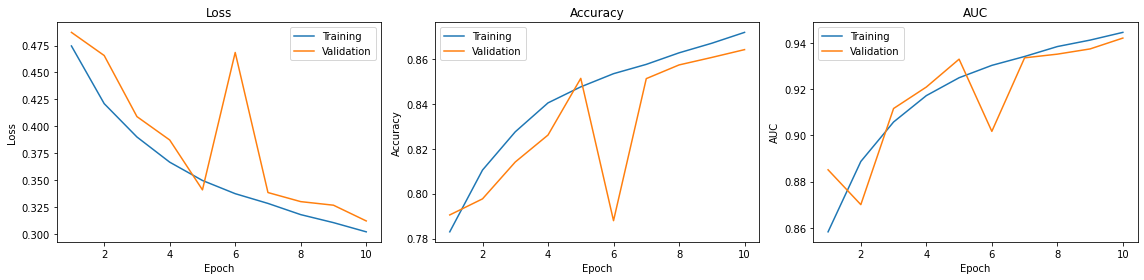

In [48]:
metrics_plot(model1_hist.history)

There seems to be rather large spike at 6 for all graphs relative to the validation data. In terms of accuracy and auc, the scores dropped at epoch 6 and loss jumped up quite a lot. I wonder if learning rate was too high and caused it go past the optimal parameters. There does seem to be still a upward trend in accuracy in AUC so maybe scores still had room to improve throuh more epochs.

Let's get see what the confusion matrix looks like on the validation data

In [70]:
y_preds = cnn_model1.predict(valid_data, verbose=1)
y_true = valid_data.classes

1113/1113 [==============================] - 49s 44ms/step


In [71]:
y_preds

array([[0.02723982],
       [0.02015659],
       [0.96996313],
       ...,
       [0.19181785],
       [0.9025394 ],
       [0.956892  ]], dtype=float32)

In [73]:
y_true[0:10]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1]

In [74]:
y_hat_labels = np.round(y_preds)
y_hat_labels[0:5]

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.]], dtype=float32)

Text(0.5, 1.0, 'Confusion Matrix')

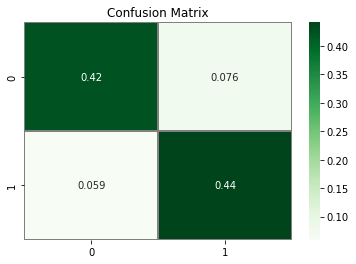

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_hat_labels)/len(y_true)
sns.heatmap(conf_mat, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.title("Confusion Matrix")

0.86 accuracy is not too bad as we can see both false positive and false negative is pretty evenly distributed. Both true scores are pretty evenly distributed as well. Let's see if the smaller model can produce a similar result.

In [30]:
model2_hist = cnn_model2.fit(x = train_data,
                            validation_data = valid_data,
                            epochs = 10,
                            verbose = 1)

Epoch 1/10
4450/4450 [==============================] - 257s 58ms/step - loss: 0.4554 - accuracy: 0.7917 - auc_1: 0.8682 - val_loss: 0.4389 - val_accuracy: 0.8008 - val_auc_1: 0.8868
Epoch 2/10
4450/4450 [==============================] - 254s 57ms/step - loss: 0.4290 - accuracy: 0.8053 - auc_1: 0.8835 - val_loss: 0.4062 - val_accuracy: 0.8195 - val_auc_1: 0.8979
Epoch 3/10
4450/4450 [==============================] - 250s 56ms/step - loss: 0.4167 - accuracy: 0.8119 - auc_1: 0.8907 - val_loss: 0.4222 - val_accuracy: 0.8104 - val_auc_1: 0.9026
Epoch 4/10
4450/4450 [==============================] - 250s 56ms/step - loss: 0.4056 - accuracy: 0.8186 - auc_1: 0.8970 - val_loss: 0.6737 - val_accuracy: 0.7477 - val_auc_1: 0.8940
Epoch 5/10
4450/4450 [==============================] - 239s 54ms/step - loss: 0.3975 - accuracy: 0.8218 - auc_1: 0.9013 - val_loss: 0.4088 - val_accuracy: 0.8240 - val_auc_1: 0.9058
Epoch 6/10
4450/4450 [==============================] - 237s 53ms/step - loss: 0.3922

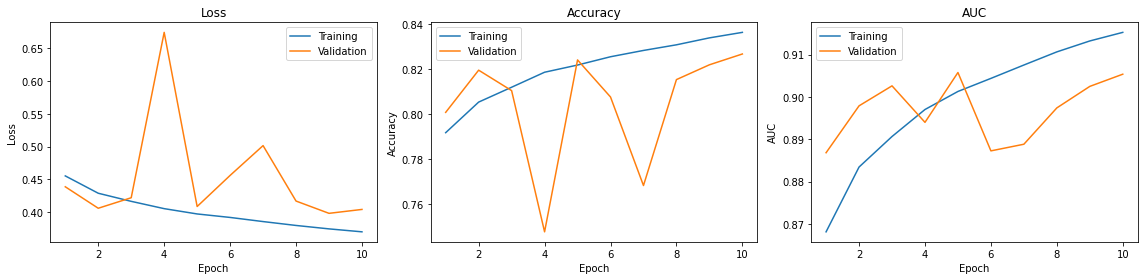

In [49]:
metrics_plot(model2_hist.history)

Well it definitely runs considerably faster, but here we get two large spikes instead of just major one in the first model relative to the validation data. With this model, it's difficult to say how much it can truly improve in the long run since the improvements is rather inconsistent and seems to flatten out a little bit. Is it worth the speed up? That's difficult to say, since it seems like a simple model isn't as good if you have a lot of gpu time.

Let's take a look at the confusion matrix.

In [81]:
y_preds2 = cnn_model2.predict(valid_data, verbose=1)

1113/1113 [==============================] - 50s 45ms/step


Text(0.5, 1.0, 'Confusion Matrix')

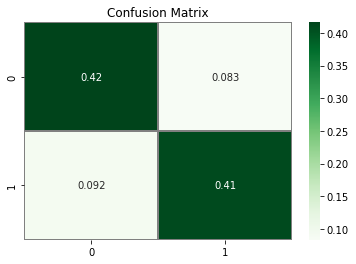

In [87]:
y_hat_labels2 = np.round(y_preds2)
conf_mat2 = confusion_matrix(y_true, y_hat_labels2)/len(y_true)
sns.heatmap(conf_mat2, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.title("Confusion Matrix")

All in all not too terrible with a 83% accuracy rate despite running a lot faster. Previous run was 86% The room for improvement with more epochs seem to be a lot less compared to that one. Both errors are pretty evenly distributed as are both positive labels.

Let's play with one of the other hyper parameters, learning rate. Instead of using the default 0.001 learning rate in the Adam optimizer, we will take this down a multitude of 10. From the previous graphs it seemed like the spikes in drops of validation accuracy and auc could be caused by the model overshooting the parameter estimates. By decreasing the learning rate, maybe we can decrease this occurance and cause for a smoother learning curve. I will attempt this change on the simpler model version since it runs faster and showed more variation in validation accuracy.

In [84]:
cnn_model3 = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu', input_shape = (96, 96, 3)),
    MaxPooling2D(2,2),
    Dropout(0.2),
    BatchNormalization(),
    
    Flatten(),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_model3.compile(optimizer = Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999), 
                   loss="binary_crossentropy", 
                   metrics = ['accuracy', tf.keras.metrics.AUC()])

cnn_model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                2211870   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [85]:
model3_hist = cnn_model3.fit(x = train_data,
                            validation_data = valid_data,
                            epochs = 10,
                            verbose = 1)

Epoch 1/10
4450/4450 [==============================] - 261s 59ms/step - loss: 0.4566 - accuracy: 0.7883 - auc_2: 0.8672 - val_loss: 0.4259 - val_accuracy: 0.8089 - val_auc_2: 0.8909
Epoch 2/10
4450/4450 [==============================] - 246s 55ms/step - loss: 0.4193 - accuracy: 0.8085 - auc_2: 0.8887 - val_loss: 0.4025 - val_accuracy: 0.8215 - val_auc_2: 0.9035
Epoch 3/10
4450/4450 [==============================] - 246s 55ms/step - loss: 0.4039 - accuracy: 0.8166 - auc_2: 0.8975 - val_loss: 0.4198 - val_accuracy: 0.8109 - val_auc_2: 0.9001
Epoch 4/10
4450/4450 [==============================] - 245s 55ms/step - loss: 0.3936 - accuracy: 0.8221 - auc_2: 0.9031 - val_loss: 0.4355 - val_accuracy: 0.8095 - val_auc_2: 0.8957
Epoch 5/10
4450/4450 [==============================] - 247s 56ms/step - loss: 0.3829 - accuracy: 0.8284 - auc_2: 0.9089 - val_loss: 0.3868 - val_accuracy: 0.8230 - val_auc_2: 0.9087
Epoch 6/10
4450/4450 [==============================] - 244s 55ms/step - loss: 0.3743

There's no impact in run time with a decrease in learning rate.

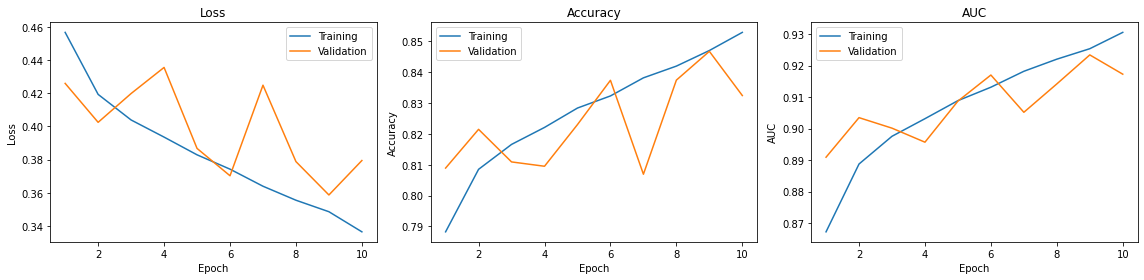

In [86]:
metrics_plot(model3_hist.history)

Well we can still see two spikes, but the spikes are less dramatic and seem to increase general validation accuracy rate at smoother rate. This is best scence in the AUC graph where the dips of the validation data are much smoother. The resulting final accuracy is higher and could be trending an increase with more epochs, which seemed a less likely to be the case with a higher learning rate.

1113/1113 [==============================] - 50s 45ms/step


Text(0.5, 1.0, 'Confusion Matrix')

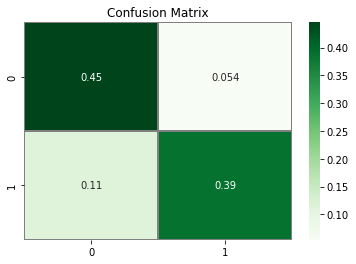

In [89]:
y_preds3 = cnn_model3.predict(valid_data, verbose=1)
y_hat_labels3 = np.round(y_preds3)
conf_mat3 = confusion_matrix(y_true, y_hat_labels3)/len(y_true)
sns.heatmap(conf_mat3, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.title("Confusion Matrix")

The accuracy rate here was about 0.84 with the percentage of true labels being predicted. However with the confusion matrix, you can see that there's more of an imbalance in the label predictions in this lower learning rate model. It seems to incorrectly predict a 0 when the real label was 1, more often than in previous models. This causes a bit of an imbalance, where this false negative error occurs twice as often as the false positive error. This causes the a little bit of an imbalance between true negative and true positive. While this accuracy is better than the higher learning rate, it is a bit debatable whether or not it is worth this slight bias.

# Conclusion

Here's a little bit of a final comparison of the models and parameters run:

| model | max_time/step | # of parameters | learning rate | train_acc | val_acc | val_auc
| ---- | ---- | ---- | ---- | --- | --- | --- | 
| model1 | 1065s 238ms | 8,868,929 | 0.001 | 0.8719 | 0.8642 | 0.9420 |
| model2 | 257s 58ms | 2,212,925 | 0.001 | 0.8363 | 0.8267 | 0.9054 |
| model3 | 261s 59ms | 2,212,925 | 0.0001 | 0.8529 | 0.8324 | 0.9173 |

It's quite interesting how quickly and accurately a deep learning model figures out the label of a cancer cell image, seeing that to the untrained eyes, it seemed like an impossible task. It seems more complicated models can learn more feature that can better help with prediction. Unfortunately more complicated models are also a lot more time consuming to run, especially for the first epoch which could be a problem for those short on time or with inconsistent hardware/internet/browser. Decreases in learning rate seem to increase accuracy scores at the risk of plateauing or some bias introduction. There also seemed to be room for gains in accuracy with more epochs at the cost of more time and possibly overfitting. Increase in epochs also might not help for small models with a default learning rate. 3x3 filters also need less parameters than larger filters such as 5x5s. Final verdict? I would pick a more complicated with more time on my hands. Perhaps lowering that model's learning rate would increase the scores since it worked with the simpler model. The only problem is that there might be a bit of bias that it might learn. If that bias isn't an issue, but time is, I would go with the smaller model, but with a lower learning rate for higher accuracy. There seems to be a lot of improvements that could be made with tuning other hyperparameters/parameters and higher epochs.

# Predict on Test Data

In [96]:
test_df = pd.read_csv(r"../input/histopathologic-cancer-detection/sample_submission.csv")
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [97]:
test_df['id'] = test_df['id'] + ".tif"
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [140]:
test_names = []

for dirname, _, filenames in os.walk('/kaggle/input/histopathologic-cancer-detection/test'):
    test_names.append(filenames)

In [153]:
test_df['id'] = test_names[0]
test_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif,0


In [163]:
# move files according to internet/google solution since flow_from_directory doesn't work without it
test_dir = 'test_set_dir'
os.mkdir(test_dir)
    
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    fname = image
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    dst = os.path.join(test_images, fname)
    shutil.copyfile(src, dst)
len(os.listdir('test_set_dir/test_images'))

57458

In [164]:
test_path = 'test_set_dir'
test_gen = datagen.flow_from_directory(test_path,
                                       target_size=(96,96),
                                       class_mode='binary',
                                       shuffle=False)

Found 57458 images belonging to 1 classes.


In [165]:
test_preds = cnn_model1.predict(test_gen, verbose=1)
test_labsl = np.round(test_preds)


1796/1796 [==============================] - 55s 31ms/step


In [176]:
test_df['label'] = test_labsl.astype('int')
test_df['id'] = [name[12:-4] for name in test_gen.filenames]
test_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [177]:
test_df.to_csv("submission.csv", index=False)

In [178]:
test_df[test_df['id'] == "0000ec92553fda4ce39889f9226ace43cae3364e"]

,id,label
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
